<a href="https://colab.research.google.com/github/MadmanMarble/MadmanMarble/blob/main/Landsat_MultiClass_U_Net_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Landsat Multi Class U-Net Modeling for Wetlands in Hawaii with NWI/CCAP label data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 54.0 MB/s eta 0:00:00


In [3]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import rasterio
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.utils import Sequence, to_categorical
import numpy as np
import rasterio
import cv2
from keras.utils import to_categorical
import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from osgeo import gdal

In [4]:
# Ensure the lists are sorted so that images and labels correspond to each other
# load landsat iamges
landsat_images = sorted(glob.glob(f"/content/drive/MyDrive/DeepLearning_Project/unet_landsat_data/landsat_images/*.tif"))
# load landsat labels
landsat_labels = sorted(glob.glob(f"/content/drive/MyDrive/DeepLearning_Project/unet_landsat_data/landsat_labels/*.tif"))

# Split the file paths into training and testing sets (85% train, 15% test)
train_images_paths, test_images_paths, train_labels_paths, test_labels_paths = train_test_split(
    landsat_images, landsat_labels, test_size=0.15, random_state=42)

In [5]:
print("Number of samples:", len(landsat_images))
print("Number of labels:", len(landsat_labels))

Number of samples: 47
Number of labels: 47


In [6]:
# List of files to copy
# files_to_copy = ['path/to/source/file1.txt', 'path/to/source/file2.jpg', 'path/to/source/file3.pdf']
# Destination directory
destination = '/content/train_images'

# Ensure the destination directory exists
os.makedirs(destination, exist_ok=True)

# Loop through the list and copy each file
for file in train_images_paths:
    # Define the full destination path for the current file
    dest_file = os.path.join(destination, os.path.basename(file))
    # Copy the file
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')



# Destination directory
destination = '/content/train_labels'

# Ensure the destination directory exists
os.makedirs(destination, exist_ok=True)

# Loop through the list and copy each file
for file in train_labels_paths:
    # Define the full destination path for the current file
    dest_file = os.path.join(destination, os.path.basename(file))
    # Copy the file
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

# Destination directory
destination = '/content/test_images'

# Ensure the destination directory exists
os.makedirs(destination, exist_ok=True)

# Loop through the list and copy each file
for file in test_images_paths:
    # Define the full destination path for the current file
    dest_file = os.path.join(destination, os.path.basename(file))
    # Copy the file
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')


# Destination directory
destination = '/content/test_labels'

# Ensure the destination directory exists
os.makedirs(destination, exist_ok=True)

# Loop through the list and copy each file
for file in test_labels_paths:
    # Define the full destination path for the current file
    dest_file = os.path.join(destination, os.path.basename(file))
    # Copy the file
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

Copied /content/drive/MyDrive/DeepLearning_Project/unet_landsat_data/landsat_images/14_landsat_stack_utm4.tif to /content/train_images/14_landsat_stack_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/unet_landsat_data/landsat_images/31_landsat_stack_utm4.tif to /content/train_images/31_landsat_stack_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/unet_landsat_data/landsat_images/18_landsat_stack_utm4.tif to /content/train_images/18_landsat_stack_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/unet_landsat_data/landsat_images/13_landsat_stack_utm4.tif to /content/train_images/13_landsat_stack_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/unet_landsat_data/landsat_images/16_landsat_stack_utm4.tif to /content/train_images/16_landsat_stack_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/unet_landsat_data/landsat_images/4_landsat_stack_utm5.tif to /content/train_images/4_landsat_stack_utm5.tif
Copied /content/drive/MyDrive/DeepLe

In [7]:

test_images_paths = sorted(glob.glob(f"/content/test_images/*.tif"))
test_labels_paths = sorted(glob.glob(f"/content/test_labels/*.tif"))


train_images_paths = sorted(glob.glob(f"/content/train_images/*.tif"))
train_labels_paths = sorted(glob.glob(f"/content/train_labels/*.tif"))


(3840, 3840)


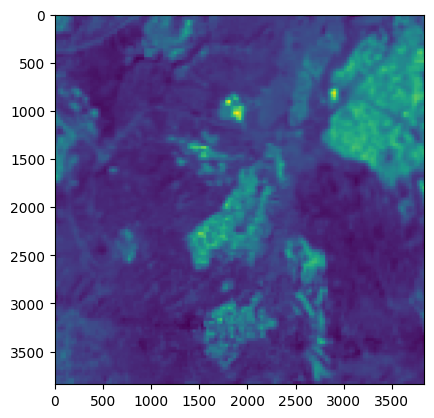

In [8]:
# What does one image and corresponding label look like?
dataset = gdal.Open(train_images_paths[15])
band = dataset.GetRasterBand(41)
array = band.ReadAsArray()
print(array.shape)
plt.imshow(array)

(3840, 3840)


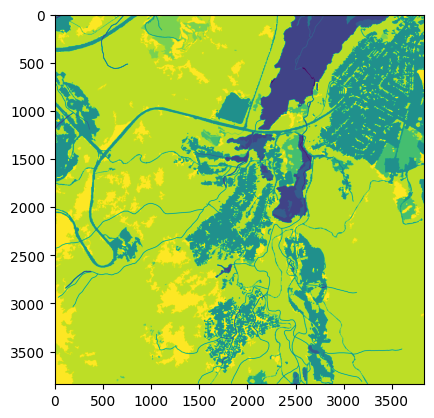

In [9]:
datasetLabel = gdal.Open(train_labels_paths[15])
band = datasetLabel.GetRasterBand(1)
array = band.ReadAsArray()
print(array.shape)
plt.imshow(array)

In [10]:
src_ds = gdal.Open(train_labels_paths[15])
if src_ds is not None:
    print ("band count: " + str(src_ds.RasterCount))

src_ds = gdal.Open(landsat_images[15])
if src_ds is not None:
    print ("band count: " + str(src_ds.RasterCount))


band count: 1
band count: 42


In [11]:
img_width,img_height=src_ds.RasterXSize,src_ds.RasterYSize
print(img_width)
print(img_height)

3840
3840


In [12]:
# Open the dataset
src_ds = gdal.Open(train_labels_paths[15])
if src_ds is not None:
    print("Band count:", src_ds.RasterCount)

    # Read the first band's data
    band = src_ds.GetRasterBand(1)
    band_data = band.ReadAsArray()

    # Find unique values in the band data
    unique_classes = np.unique(band_data)
    print("Unique classes:", unique_classes)

Band count: 1
Unique classes: [ 1.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


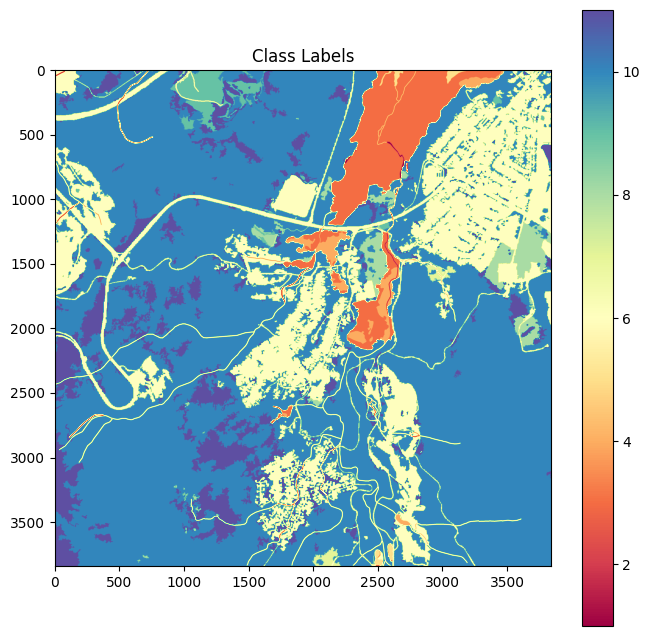

In [13]:
# Use a colormap to visualize the classes
plt.figure(figsize=(8, 8))
plt.imshow(band_data, cmap='Spectral')  # Choose a colormap that fits the number of your classes
plt.colorbar()
plt.title('Class Labels')
plt.show()

In [15]:
# Open the dataset
src_ds = gdal.Open(train_images_paths[15])
if src_ds is not None:
    print("Band count:", src_ds.RasterCount)

    # Read the first band's data
    band = src_ds.GetRasterBand(4)
    band_data = band.ReadAsArray()

    # Find unique values in the band data
    unique_classes = np.unique(band_data)
    print("Unique classes:", unique_classes)

Band count: 42
Unique classes: [ 638.4756   722.3297   749.00323 ... 8318.973   9423.013   9485.828  ]


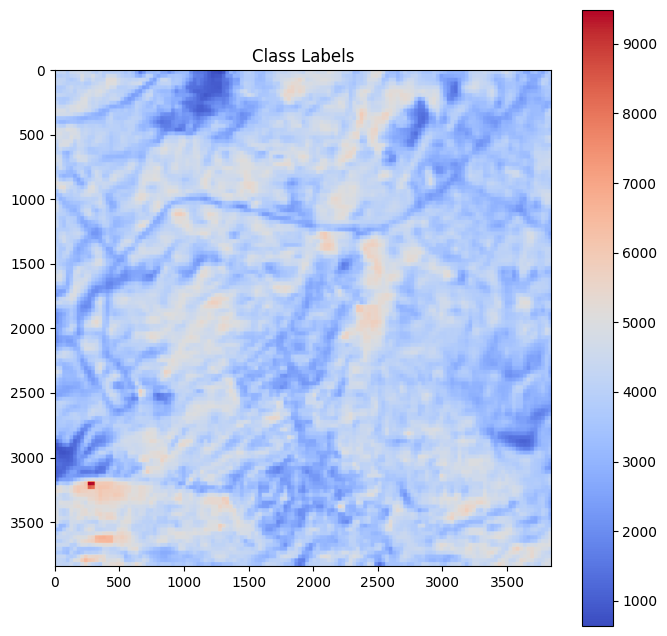

In [16]:
# Use a colormap to visualize the classes
plt.figure(figsize=(8, 8))
plt.imshow(band_data, cmap='coolwarm')  # Choose a colormap that fits the number of your classes
plt.colorbar()
plt.title('Class Labels')
plt.show()

In [17]:
#Resizing images, if needed
SIZE_X = 128
SIZE_Y = 128
n_classes= 13 #Number of classes for segmentation
batch_size = 8 #64

In [40]:

class DataGenerator(Sequence):
    def __init__(self, image_files, label_files, img_height, img_width, batch_size, num_classes):
        self.image_files = image_files
        self.label_files = label_files
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.num_classes = num_classes

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        image_batch_files = self.image_files[index * self.batch_size : (index + 1) * self.batch_size]
        label_batch_files = self.label_files[index * self.batch_size : (index + 1) * self.batch_size]

        batch_images, batch_labels = self.load_images_and_labels(image_batch_files, label_batch_files)
        return batch_images, batch_labels

    def load_and_reshape_image(self, image_path):
        with rasterio.open(image_path) as src:
            image = src.read().transpose((1, 2, 0))
            if image.shape[:2] != (self.img_height, self.img_width):
                image = cv2.resize(image, (self.img_width, self.img_height), interpolation=cv2.INTER_NEAREST)
        return image

    # def z_score_normalization(self, image):
    #     # epsilon = 1e-7
    #     # mean = np.mean(image, axis=(0, 1), keepdims=True)
    #     # std = np.std(image, axis=(0, 1), keepdims=True)
    #     # std[std < 0] = 0
    #     # normalized_image = (image - mean) / (std + epsilon)

    #     min = np.min(image, axis=(0, 1), keepdims=True)
    #     max = np.max(image, axis=(0, 1), keepdims=True)
    #     normalized_image = (image - min) / (max - min)


    #     return normalized_image

    def z_score_normalization(self, image):
        image = image.astype(np.float32)  # Ensure the image is in float format to handle division and large ranges

        min_val = np.min(image, axis=(0, 1), keepdims=True)
        max_val = np.max(image, axis=(0, 1), keepdims=True)
        range_val = max_val - min_val

        # Avoid division by zero by checking if range is 0
        if np.any(range_val == 0):
            normalized_image = np.zeros(image.shape, dtype=np.float32)
        else:
            normalized_image = (image - min_val) / range_val

        return normalized_image




# data = np.random.normal(loc=0, scale=1, size=(96108, 7, 7))
# data_min = np.min(data, axis=(1,2), keepdims=True)
# data_max = np.max(data, axis=(1,2), keepdims=True)

# scaled_data = (data - data_min) / (data_max - data_min)

    def load_images_and_labels(self, image_files, label_files):
        images = [self.load_and_reshape_image(image_file) for image_file in image_files]
        labels = [self.load_and_reshape_image(label_file) for label_file in label_files]

        # Apply Z-score normalization to images
        normalized_images = [self.z_score_normalization(image) for image in images]

        # Process labels if necessary (for example, converting to categorical)
        processed_labels = [to_categorical(label, num_classes=self.num_classes) for label in labels]

        # fix potential shape mismatch in labels
        processed_labels = np.squeeze(processed_labels, axis=None) # adjust based on label shape



        return np.array(normalized_images), processed_labels  # np.array(processed_labels)

In [32]:
import tensorflow as tf

In [41]:
train_data_generator = DataGenerator(train_images_paths, train_labels_paths, SIZE_X, SIZE_Y, batch_size, n_classes)
test_data_generator = DataGenerator(test_images_paths, test_labels_paths, SIZE_X, SIZE_Y, batch_size, n_classes)

In [42]:
batch_images, batch_labels = train_data_generator.__getitem__(0)

In [43]:
batch_images

array([[[[0.02616587, 0.05192616, 0.04667076, ..., 0.23871362,
          0.1627625 , 0.25457606],
         [0.0489615 , 0.08131212, 0.08535899, ..., 0.28871906,
          0.23353022, 0.25019   ],
         [0.10193439, 0.14266944, 0.1565255 , ..., 0.33855107,
          0.2891372 , 0.24750386],
         ...,
         [0.08366293, 0.10563833, 0.11995046, ..., 0.2475591 ,
          0.27628425, 0.11070043],
         [0.08072306, 0.10380334, 0.11804953, ..., 0.25263834,
          0.28763548, 0.11042447],
         [0.08025581, 0.10539351, 0.11999063, ..., 0.2705059 ,
          0.29674482, 0.11097535]],

        [[0.02102221, 0.04868611, 0.04173103, ..., 0.2133427 ,
          0.15184647, 0.25233653],
         [0.07764211, 0.12530172, 0.12812835, ..., 0.31169906,
          0.25296533, 0.24763846],
         [0.27008063, 0.33703846, 0.39446485, ..., 0.4872487 ,
          0.45472014, 0.24339266],
         ...,
         [0.1502282 , 0.17282957, 0.1880176 , ..., 0.28501198,
          0.33474055, 0.1

In [44]:
batch_labels

array([[[[0., 0., 0., ..., 1., 0., 0.],
         [0., 0., 0., ..., 1., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 1., 0., 0.],
         [0., 0., 0., ..., 1., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 1., 0., 0.],
         [0., 0., 0., ..., 1., 0., 0.],
         [0., 0., 0., ..., 1., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
    

In [45]:
print(batch_images.shape)
print(batch_labels.shape)

(8, 128, 128, 42)
(8, 128, 128, 13)


In [46]:
print('Number of files in train labels:', len(batch_images))
print('Number of files in test labels:', len(batch_images))

print('Number of files in train labels:', len(batch_labels))
print('Number of files in test labels:', len(batch_labels))

Number of files in train labels: 8
Number of files in test labels: 8
Number of files in train labels: 8
Number of files in test labels: 8


In [47]:
def multi_unet_model(n_classes=13, IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=42):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(n_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [48]:
model = multi_unet_model(n_classes=13, IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=42)

In [49]:
print(model.summary()) # 2,073,101

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 42)]       0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 64, 64, 32)           12128     ['input_3[0][0]']             
                                                                                                  
 batch_normalization_30 (Ba  (None, 64, 64, 32)           128       ['conv2d_18[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_30 (Activation)  (None, 64, 64, 32)           0         ['batch_normalization_30

In [50]:
model.compile(optimizer= Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', "categorical_accuracy"])
callbacks = [keras.callbacks.ModelCheckpoint(filepath='landsat_lr001_batch8.h5', save_best_only=True)]


In [51]:
model.fit(train_data_generator, validation_data= test_data_generator, epochs=10, callbacks=callbacks,shuffle=True)

Epoch 1/10
1/5 [=====>........................] - ETA: 12:18 - loss: 6.7872 - accuracy: 0.2371 - categorical_accuracy: 0.2371

InvalidArgumentError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (8, 128, 128) + inhomogeneous part.
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/data_adapter.py", line 1064, in generator_fn
    yield x[i]

  File "<ipython-input-40-61dff49f3a7a>", line 17, in __getitem__
    batch_images, batch_labels = self.load_images_and_labels(image_batch_files, label_batch_files)

  File "<ipython-input-40-61dff49f3a7a>", line 80, in load_images_and_labels
    return np.array(normalized_images), processed_labels  # np.array(processed_labels)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (8, 128, 128) + inhomogeneous part.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) INVALID_ARGUMENT:  ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (8, 128, 128) + inhomogeneous part.
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/data_adapter.py", line 1064, in generator_fn
    yield x[i]

  File "<ipython-input-40-61dff49f3a7a>", line 17, in __getitem__
    batch_images, batch_labels = self.load_images_and_labels(image_batch_files, label_batch_files)

  File "<ipython-input-40-61dff49f3a7a>", line 80, in load_images_and_labels
    return np.array(normalized_images), processed_labels  # np.array(processed_labels)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (8, 128, 128) + inhomogeneous part.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_29194]

In [30]:
print(train_data_generator)
print(test_data_generator)

In [31]:
for batch_images, batch_labels in train_data_generator:
  print(batch_images.shape)
  print(batch_labels.shape)
  break

for batch_images, batch_labels in test_data_generator:
  print(batch_images.shape)
  print(batch_labels.shape)
  break

(8, 128, 128, 42)
(8, 128, 128, 13)
(8, 128, 128, 42)
(8, 128, 128, 13)
